In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install -e ~/Workspace/AI4Finance/FinRL

In [30]:
!pip install -e ~/Workspace/AI4Finance/FinRL

Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-4mez9tnp/elegantrl_93f37d8f1b8644d1b0f88e15216b6f06
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-4mez9tnp/elegantrl_93f37d8f1b8644d1b0f88e15216b6f06
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5bca7aeeb73f5779788dd6714a53b59ce880c583
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9103 sha256=ebb9a360ce7d0d9eb

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_stock_trading.env_stocktrading_stacking import StockTradingStackingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent, DRLStackingAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
import itertools

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2023-11-10'
TEST_START_DATE = '2023-11-11'
TEST_END_DATE = '2024-11-11'


INDICATORS = ['macd',
              'rsi_30',
              'cci_30',
              'dx_30']

In [4]:
if False:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed.to_csv("datasets/processed.csv", index=False)

In [5]:
processed = pd.read_csv("datasets/processed.csv")

In [6]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + 5 * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 82, State Space: 903


In [7]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [9]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

stacking_agent = DRLStackingAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)


In [10]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

timesteps_dict = {'model_6' : 10000}

In [12]:
df_summary = stacking_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)

turbulence_threshold:  598.6223450035029
======Model training from:  2010-01-01 to  2023-11-13
======model_6 Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/model_6/model_6_126_7
-------------------------------------
| time/                 |           |
|    fps                | 13        |
|    iterations         | 100       |
|    time_elapsed       | 38        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -116      |
|    explained_variance | 0.0674    |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -196      |
|    reward             | 1.2557746 |
|    std                | 0.998     |
|    value_loss         | 6.37      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 13        |
|    iterations         | 2

In [13]:
df_summary

,Iter,Val Start,Val End,Stacking Model Used
0,126,2023-11-13,2024-02-14,MODEL_6
1,189,2024-02-14,2024-05-15,MODEL_6


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [14]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [15]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('stacking',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.06373842823148375


In [18]:
df_account_value

,account_value,date,daily_return,datadate
0,1.000000e+06,2024-02-14,NaN,2024-02-14
1,1.009544e+06,2024-02-15,0.009544,2024-02-15
2,1.014328e+06,2024-02-16,0.004739,2024-02-16
3,1.001444e+06,2024-02-20,-0.012702,2024-02-20
4,9.980034e+05,2024-02-21,-0.003436,2024-02-21
...,...,...,...,...
121,9.423728e+05,2024-08-08,-0.011661,2024-08-08
122,9.597802e+05,2024-08-09,0.018472,2024-08-09
123,9.668976e+05,2024-08-12,0.007416,2024-08-12
124,9.768819e+05,2024-08-13,0.010326,2024-08-13


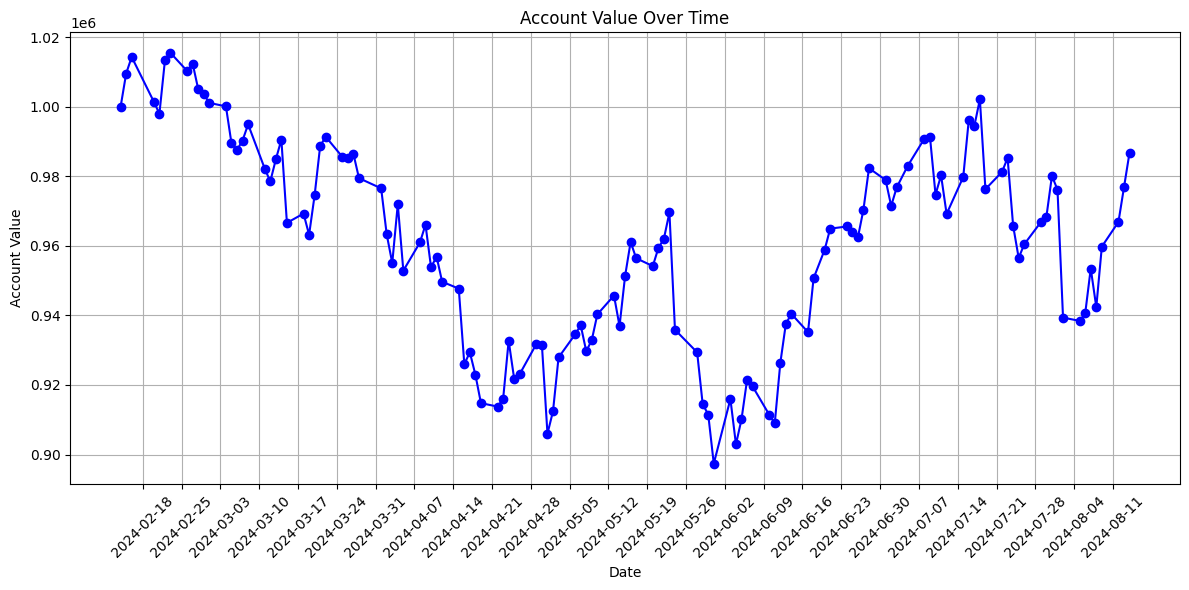

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the date column to datetime format
df_account_value['date'] = pd.to_datetime(df_account_value['date'])

# Set the date column as the index
df_account_value.set_index('date', inplace=True)

# Visualization 1: Line plot for account value over time, with weekly xticks
plt.figure(figsize=(12, 6))
plt.plot(df_account_value.index, df_account_value['account_value'], marker='o', color='b')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value.index.min(), end=df_account_value.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

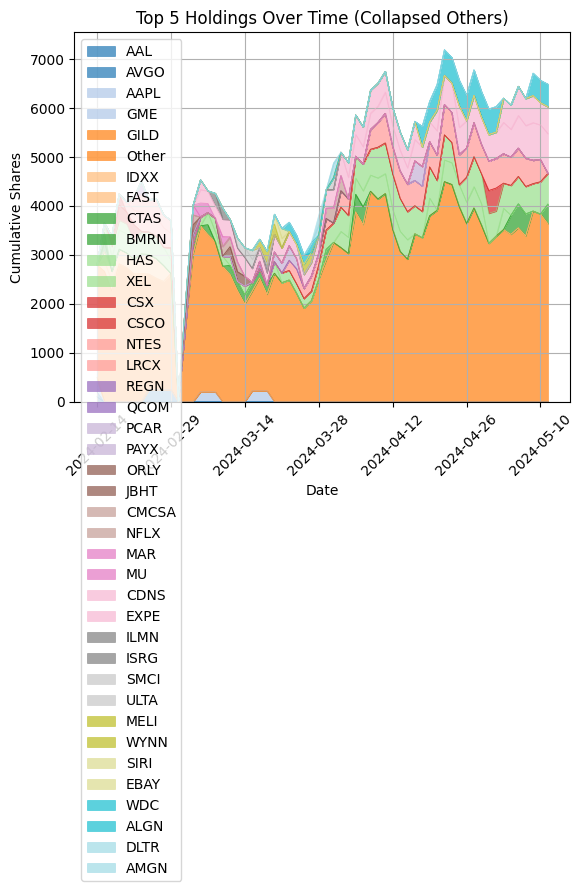

In [35]:
df = pd.read_csv("results/actions_trade_stacking_126.csv")

# Assuming the columns are in the format ['date', '<stock1>', '<stock2>', ...]
dates = df['date']
stocks = df.columns[1:]

# Calculate cumulative sum of shares
cumulative_shares = df[stocks].cumsum()


# Function to get top 5 holdings and collapse the rest into "Other"
def top_5_holdings(cumulative_df):
    top_5_list = []
    for index, row in cumulative_df.iterrows():
        row_values = row.sort_values(ascending=False)
        top_5 = row_values[:5]
        others = row_values[5:].sum()
        top_5['Other'] = others
        top_5_list.append(top_5)
    return pd.DataFrame(top_5_list, index=cumulative_df.index)


# Get top 5 holdings plus 'Other'
top_5_df = top_5_holdings(cumulative_shares)
top_5_df['date'] = dates

# Visualization: Stacked Area Chart
plt.figure(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(top_5_df.columns[:-1])))
top_5_df.set_index('date').plot(kind='area', stacked=True, color=colors, linewidth=0.5, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Cumulative Shares')
plt.title('Top 5 Holdings Over Time (Collapsed Others)')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
cumulative_shares

,AAL,AAPL,ADBE,ADI,ADP,ADSK,ALGN,AMAT,AMD,AMGN,...,TXN,UAL,ULTA,VRSK,VRSN,VRTX,WBA,WDC,WYNN,XEL
0,100,100,0,0,0,0,13,86,100,0,...,35,0,0,91,0,0,0,27,100,12
1,0,66,0,0,0,0,0,0,100,0,...,35,0,0,91,0,0,0,0,100,112
2,0,66,0,0,100,0,0,0,0,0,...,0,0,0,0,0,0,0,0,90,212
3,0,66,0,0,100,0,0,0,0,0,...,100,1,100,0,0,0,0,1,0,201
4,0,42,1,0,31,0,0,0,0,0,...,100,0,100,0,0,0,0,1,0,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,0,0,0,0,0,0,0,0,144,...,100,111,0,0,0,0,0,359,4,560
58,0,0,0,0,0,0,0,0,0,144,...,0,111,0,0,0,0,0,359,4,560
59,0,100,0,0,0,0,98,0,0,144,...,0,111,0,0,0,100,1,459,104,560
60,3,100,0,0,0,0,0,0,0,144,...,0,111,0,0,0,100,0,459,104,660


<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [20]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.026129
Cumulative returns    -0.013151
Annual volatility      0.176069
Sharpe ratio          -0.063738
Calmar ratio          -0.224627
Stability              0.060176
Max drawdown          -0.116322
Omega ratio            0.989706
Sortino ratio         -0.082627
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.846623
Daily value at risk   -0.022227
dtype: float64


In [21]:
%load_ext tensorboard

In [22]:
%tensorboard --logdir ./tensorboard_log/

In [25]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (125, 8)
Annual return          0.057152
Cumulative returns     0.027952
Annual volatility      0.114338
Sharpe ratio           0.546898
Calmar ratio           0.971835
Stability              0.224720
Max drawdown          -0.058808
Omega ratio            1.096895
Sortino ratio          0.752622
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912030
Daily value at risk   -0.014157
dtype: float64


In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

print("df_trade_date: ", df_trade_date)
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [28]:
import scipy as scipy_version_test
scipy_version_test.__version__
scipy_version_test.__numpy_version__


'1.26.4'

In [29]:
import sklearn as sklearn_version_test
sklearn_version_test.__version__


'1.5.2'